# Прогнозирование потребления электроэнергии на этапе обработки стали металлургического предприятия
**Выпускной проект Яндекс.Практикум - Data Science**

## Описание проекта

Прогнозирование потребления электроэнергии на этапе обработки стали позволит металлургическому комбинату оптимизировать производственные расходы.

**Исходные данные:**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

**Цель проекта:**

Построить модель, которая предскажет температуру стали, что позволит уменьшить потребление электроэнергии на этапе обработки стали.
Метрикой качества является MAE. 

Необходимо получить на тестовых данных **MAE < 6.0**

**Условия задачи:**

Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, установленные в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный tribe-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

### Структура проекта
* [1. Загрузка и изучение общей информации датасета](#start)
* [2. Предобработка данных](#preprocessing)
    * [2.1 Изменение типов данных](#types)
    * [2.2 Обработка пропусков](#nan)
    * [2.3 Выделение начальной и конечной температуры](#temp)
    * [2.4 Расчёт суммарного времени нагрева и числа нагревов](#heat)
    * [2.5 Объединение таблиц](#merge)
* [3. Исследовательский анализ данных](#eda)
* [4. Построение модели](#model)
    * [4.1 Подготовка данных для обучения моделей](#prepare)
    * [4.2 Обучение и сравнение моделей](#fit)
* [5. Тестирование модели](#testing)
* [6. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка и изучение общей информации датасета

#### Импортируем необходимые библиотеки

In [1]:
import time as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import catboost as ct
import shap as shap
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from catboost import Pool
import probscale


print(f"Pandas version: {pd.__version__}")
print(f"sklearn version: {sk.__version__}")
print(f"CatBoost version: {ct.__version__}")

Pandas version: 1.3.0
sklearn version: 0.24.2
CatBoost version: 0.25.1


#### Загрузим данные

In [2]:
# input path of datasets
PATH = input()

../datasets/


In [3]:
list_df = []
dataset_arc  = 'data_arc.csv'
dataset_bulk = 'data_bulk.csv'
dataset_bulk_time = 'data_bulk_time.csv'
dataset_gas  = 'data_gas.csv'
dataset_temp = 'data_temp.csv'
dataset_wire = 'data_wire.csv'
dataset_wire_time = 'data_wire_time.csv'

try:
    df_arc = pd.read_csv(f'{PATH}{dataset_arc}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_arc}')
    df_bulk = pd.read_csv(f'{PATH}{dataset_bulk}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_bulk}"')
    df_bulk_time = pd.read_csv(f'{PATH}{dataset_bulk_time}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_bulk_time}"')
    df_gas = pd.read_csv(f'{PATH}{dataset_gas}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_gas}"')
    df_temp = pd.read_csv(f'{PATH}{dataset_temp}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_temp}"')
    df_wire = pd.read_csv(f'{PATH}{dataset_wire}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_wire}"')
    df_wire_time = pd.read_csv(f'{PATH}{dataset_wire_time}', sep=',')
    print(f'Прочитан файл с данными: "{dataset_wire_time}"')
    list_df.extend([df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time])
except Exception as err:
    print(repr(err))

Прочитан файл с данными: "data_arc.csv
Прочитан файл с данными: "data_bulk.csv"
Прочитан файл с данными: "data_bulk_time.csv"
Прочитан файл с данными: "data_gas.csv"
Прочитан файл с данными: "data_temp.csv"
Прочитан файл с данными: "data_wire.csv"
Прочитан файл с данными: "data_wire_time.csv"


Дополнительно создадим словарь для удобства вывода на печать описания датасета

In [4]:
df_descriptions = {
    'df_arc': 'данные об электродах',
    'df_bulk': 'данные о подаче сыпучих материалов (объём)',
    'df_bulk_time': 'данные о подаче сыпучих материалов (время)',
    'df_gas': 'данные о продувке сплава газом',
    'df_temp': 'результаты измерения температуры',
    'df_wire': 'данные о проволочных материалах (объём)',
    'df_wire_time': 'данные о проволочных материалах (время)'
}

# Get name of dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

#### Посмотрим на содержание данных

In [5]:
df_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
df_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [8]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
df_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [10]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [11]:
df_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [12]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [14]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [15]:
df_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [17]:
df_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


#### Вывод:
- в данных по электродам и по продувке газом отсутствуют пропуски
- в данных по по замерам температуры присутствуют пропуски, так же выявлено, что на каждую партию может быть несколько замеров
- в данных о подаче сыпучих материалов и проволочных материалов имеются пропуски данных
- количество пропусков в столбцах по данным об объёмах и времени подачи материалов совпадают
- на каждую партию может быть несколько замеров температуры и несколько данных об электродах на разные моменты времени

<a id="preprocessing"></a>
## 2. Предобработка данных

#### Проверим есть ли дубликаты

In [19]:
key_duplicate = False
for df in list_df:
    if df.duplicated().sum() > 0:
        key_duplicate = True
        print(f"Есть дублированные данные в датасете '{get_df_name(df)}'")

if key_duplicate == False:
    print('В данных нет дубликатов')


В данных нет дубликатов


#### Проверим, что у нас на каждую партию по одной записи о подаче материалов и о продувке газом

In [20]:
key_duplicate = False
for df in [df_bulk, df_bulk_time, df_wire, df_wire_time, df_gas]:
    if len(df['key'].value_counts().unique()) > 1:
        key_duplicate = True
        break

if key_duplicate:
    print('Есть дублирование записей о подаче материалов или газа для одной партии.')
else:
    print('На каждую партию не более одной записи о подаче материалов и о продувке газом')

На каждую партию не более одной записи о подаче материалов и о продувке газом


<a id="types"></a>
### 2.1 Изменение типов данных

#### Приведём столбцы с временем к типу `datetime`

In [21]:
COUNT_BULK = 15
COUNT_WIRE = 9

df_arc['begin_heat'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['end_heat'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_temp['datetime'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

for i in range(1,COUNT_BULK+1):
    df_bulk_time[f"Bulk {i}"] = pd.to_datetime(df_bulk_time[f"Bulk {i}"], format='%Y-%m-%d %H:%M:%S')
    
for i in range(1,COUNT_WIRE+1):
    df_wire_time[f"Wire {i}"] = pd.to_datetime(df_wire_time[f"Wire {i}"], format='%Y-%m-%d %H:%M:%S')

<a id="nan"></a>
### 2.2 Обработка пропусков
Обработаем пропуски, так как некоторые алгоритмы машинного обучения не умеют работать с пропусками.

Проверим какая доля заполенных данных по каждому столбцу

In [22]:
df_bulk.apply(lambda x: f"{(x.count()/len(x))*100:.2f}%")

key        100.00%
Bulk 1       8.05%
Bulk 2       0.70%
Bulk 3      41.48%
Bulk 4      32.41%
Bulk 5       2.46%
Bulk 6      18.41%
Bulk 7       0.80%
Bulk 8       0.03%
Bulk 9       0.61%
Bulk 10      5.62%
Bulk 11      5.66%
Bulk 12     78.30%
Bulk 13      0.58%
Bulk 14     89.68%
Bulk 15     71.84%
dtype: object

In [23]:
df_wire.apply(lambda x: f"{(x.count()/len(x))*100:.2f}%")

key       100.00%
Wire 1     99.16%
Wire 2     35.02%
Wire 3      2.04%
Wire 4      0.45%
Wire 5      0.03%
Wire 6      2.37%
Wire 7      0.36%
Wire 8      0.62%
Wire 9      0.94%
dtype: object

Наблюдаем, что по некоторым типам материалов почти нет данных. Установим порог наличия пропусков по которому избавимся от данных. Если данных слишком мало, то они не помогут нам для построения модели.

In [24]:
TRESHOLD_COUNT_NOT_NAN = 0.05 # 5% treshold of not nan values

columns = df_bulk.columns
for clmn in columns:
    if (df_bulk[clmn].count() / df_bulk.shape[0]) < TRESHOLD_COUNT_NOT_NAN:
        df_bulk = df_bulk.drop(clmn, axis=1)
        df_bulk_time = df_bulk_time.drop(clmn, axis=1)
        
columns = df_wire.columns
for clmn in columns:
    if (df_wire[clmn].count() / df_wire.shape[0]) < TRESHOLD_COUNT_NOT_NAN:
        df_wire = df_wire.drop(clmn, axis=1)
        df_wire_time = df_wire_time.drop(clmn, axis=1)

In [25]:
print(f"Число записей о подаче сыпучих материалов (объём): {df_bulk.shape[0]}")
print(f"Число записей о подаче сыпучих материалов (время): {df_bulk.shape[0]}")
print(f"Число записей о подаче проволоных материалов (объём): {df_wire.shape[0]}")
print(f"Число записей о подаче проволочных материалов (время): {df_wire_time.shape[0]}")

Число записей о подаче сыпучих материалов (объём): 3129
Число записей о подаче сыпучих материалов (время): 3129
Число записей о подаче проволоных материалов (объём): 3081
Число записей о подаче проволочных материалов (время): 3081


Заменим пропуски на нули из предположения, что пропуск это отсутствие добавление материала

In [26]:
df_bulk = df_bulk.fillna(0)
df_bulk_time = df_bulk_time.fillna(0)
df_wire = df_wire.fillna(0)
df_wire_time = df_wire_time.fillna(0)

Проверим какие столбцы у нас остались

In [27]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 6   3129 non-null   float64
 5   Bulk 10  3129 non-null   float64
 6   Bulk 11  3129 non-null   float64
 7   Bulk 12  3129 non-null   float64
 8   Bulk 14  3129 non-null   float64
 9   Bulk 15  3129 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 244.6 KB


In [28]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


#### Избавимся от данных с пропусками по замерам температуры
Конечная температура является целевым признаком, и если целевой признак NaN, то мы не сможем работать с такими данными

In [29]:
df_temp = df_temp.dropna()

У нас по каждой партии должно минимум 2 замера, тогда если замер 1, то такие партии мы не сможем использовать по условию задачи

In [30]:
df_temp = df_temp[df_temp['key'].isin(df_temp['key'].value_counts()[df_temp['key'].value_counts()>1].index)] # very complex
df_temp.shape

(12265, 4)

<a id="temp"></a>
### 2.3 Выделение начальной и конечной температуры
По условию задачи целевым признаком является конечная температура, а температуры между начальной и конечно мы отбрасываем

In [31]:
df_temp_first = pd.merge(df_temp.groupby('key')['datetime'].agg('min'), df_temp, how="left", on="datetime")
df_temp_last = pd.merge(df_temp.groupby('key')['datetime'].agg('max'), df_temp, how="left", on="datetime")
df = pd.merge(df_temp_first[['key','Температура']], df_temp_last[['key','Температура']], how="outer", on="key")
df = df.rename(columns={'Температура_x': 'temperature_first', 'Температура_y': 'temperature_last'})

Посчитаем время между замерами температуры

In [32]:
df = pd.merge(df, df_temp[['key','datetime']].groupby('key')['datetime'].agg(lambda x: x.max()-x.min()).dt.total_seconds(), how='left', on='key')
df = df.rename(columns={'datetime': 'measurement_time'})
df.head(5)

,key,temperature_first,temperature_last,measurement_time
0,1,1571.0,1613.0,861.0
1,2,1581.0,1602.0,1305.0
2,3,1596.0,1599.0,1300.0
3,4,1601.0,1625.0,388.0
4,5,1576.0,1602.0,762.0


In [33]:
df['measurement_time'].describe()

count     2475.000000
mean      1854.953939
std       1301.241764
min        234.000000
25%       1182.500000
50%       1593.000000
75%       2262.500000
max      23537.000000
Name: measurement_time, dtype: float64

Наблюдаем аномальный выброс в длительности между первым и последним замерами

<a id="heat"></a>
### 2.4 Расчёт суммарного времени нагрева и числа нагревов

In [34]:
df_arc['heat_time'] = (df_arc['end_heat'] - df_arc['begin_heat']).dt.total_seconds()
df_del = df_arc[['key','heat_time']].groupby('key', as_index=False).agg(['sum','count'])
df_del.columns = ['heat_time', 'heat_count']
df = pd.merge(df, df_del, how='left', on='key')
del df_del

In [35]:
df[['heat_time', 'heat_count']].describe()

,heat_time,heat_count
count,2475.000000,2475.000000
mean,799.951919,4.625859
std,340.784276,1.610087
min,57.000000,1.000000
25%,573.000000,4.000000
50%,772.000000,4.000000
75%,986.500000,6.000000
max,4189.000000,16.000000


<a id="merge"></a>
### 2.5 Объединение таблиц

И установим номер партии как индекс

In [36]:
df = pd.merge(df, df_gas, how="left", on=["key"])
df = pd.merge(df, df_wire, how="left", on=["key"])
df = pd.merge(df, df_bulk, how="left", on=["key"])
df = pd.merge(df, df_arc[['key', 'Активная мощность','Реактивная мощность']].groupby('key').sum(), how="left", on=["key"]) # sum of powers
df = df.set_index('key')
df.head(5)

,temperature_first,temperature_last,measurement_time,heat_time,heat_count,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Активная мощность,Реактивная мощность
key,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,29.749986,60.059998,0.00000,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,4.878147,3.183241
2,1581.0,1602.0,1305.0,811.0,4,12.555561,96.052315,0.00000,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,3.052598,1.998112
3,1596.0,1599.0,1300.0,655.0,5,28.554793,91.160157,0.00000,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,2.525882,1.599076
4,1601.0,1625.0,388.0,741.0,4,18.841219,89.063515,0.00000,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,3.209250,2.060298
5,1576.0,1602.0,762.0,869.0,4,5.413692,89.238236,9.11456,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,3.347173,2.252643


<a id="eda"></a>
## 3. Исследовательский анализ данных

#### Проверим по каким партиям отсутствуют даннные о подаче сыпучих материалов и продувке газом

In [37]:
list_df = [df_bulk, df_wire, df_gas]

for _df in list_df:
    print(f"В таблице {df_descriptions[get_df_name(_df)]} отсутствуют записи по следующим партиям:")
    print(df_temp.loc[~df_temp['key'].isin(_df['key']), 'key'].unique())
    print()

В таблице данные о подаче сыпучих материалов (объём) отсутствуют записи по следующим партиям:
[  51   52   53   54   55   56   72   80   81  110  151  188  225  269
  302  330  331  332  343  350  661  830  874  931  933  934  960  961
  964  966  983  984 1062 1105 1221 1268 1334 1402 1517 1518 1535 1566
 1623 1656 1783 1818 1911 1959 1974 1979 2009 2010 2043 2056 2195 2196
 2197 2198 2216 2217 2231 2310 2390 2408 2434 2460 2468 2471]

В таблице данные о проволочных материалах (объём) отсутствуют записи по следующим партиям:
[  51   52   53   54   55   56   81   82   83   84   85   88  109  197
  209  210  211  212  269  330  331  332  375  376  377  378  711  712
  713  714  715  744  748  754  755  796  797  798  799  800  841  929
  930  931  932  933  934 1102 1103 1104 1105 1106 1107 1184 1379 1380
 1525 1526 1527 1528 1564 1565 1566 1646 1743 1744 1745 1746 1747 1748
 1758 1817 1818 1836 1946 1977 1978 1979 2010 2043 2195 2196 2197 2198
 2214 2215 2216 2217 2218 2219 2236 2238 2

Отсутствуют партии по которым нет данных и по поданным материалам и по продувке газом.

Необходимы консультации с заказчиком для того, чтобы определить, что делать с партиями по которым не записей по материалам или по продувке

#### Построим график замеров температуры от времени

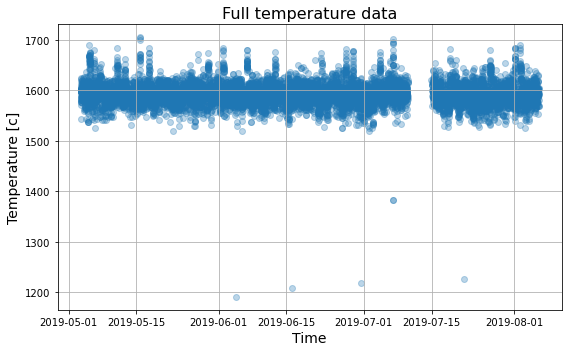

In [38]:
plt.figure(figsize=(8,5))
plt.title('Full temperature data', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel("Temperature [c]", fontsize=14)
plt.scatter(x=df_temp['datetime'], y=df_temp['Температура'], alpha=0.3)
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
print(f"Интервал наблюдений: {df_temp['datetime'].min()} - {df_temp['datetime'].max()}")

Интервал наблюдений: 2019-05-03 11:16:18 - 2019-08-06 03:00:28


Построим график распределения измерений температур

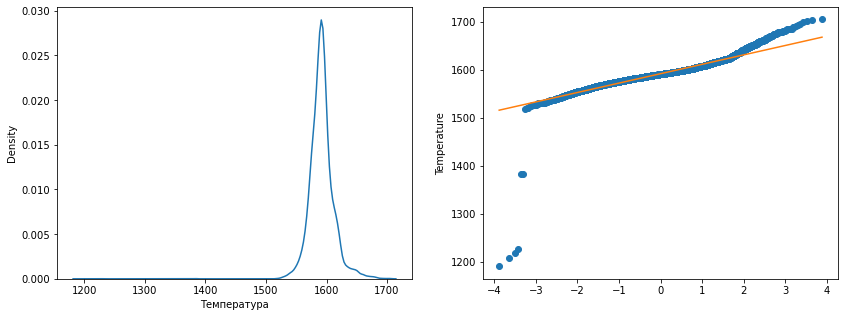

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(df_temp['Температура'], ax=ax[0])
fig = probscale.probplot(
    df_temp['Температура'],
    ax=ax[1],
    plottype='qq',
    bestfit=True
)
ax[1].set_ylabel('Temperature')
plt.show()

Построим накопительный график измерений температур

Наблюдаем некоторые выбросы в замерах и перерыв в замерах на несколько дней. Изменений со временем в измерениях не выявлено.

#### Построим график замеров начальной температуры и конечной температуры по партиям

Создадим функцию построения графиков scatter и boxplot

In [41]:
def plot_scatter_box(df, columns, size=(13,5), alpha=0.5, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
    fig.set_size_inches(size)
    ax[0].set_title(title, fontsize=16)
    ax[0].set_xlabel(xlabel, fontsize=14)
    ax[0].set_ylabel(ylabel, fontsize=14)
    for clm in columns:
        ax[0].scatter(x=df.index, y=df[clm], label=clm, alpha=alpha) 
    if len(columns) > 1:
        ax[0].legend()
    ax[0].grid(True)
    ax[1].boxplot(df[columns], labels=[*columns])
    plt.tight_layout()
    plt.show()

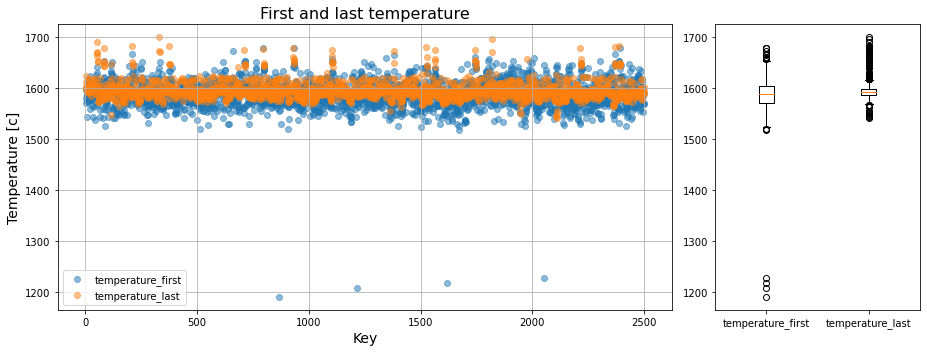

In [42]:
plot_scatter_box(df, ['temperature_first','temperature_last'], title='First and last temperature', xlabel='Key', ylabel='Temperature [c]')

In [43]:
df[['temperature_first','temperature_last']].describe()

,temperature_first,temperature_last
count,2475.000000,2475.000000
mean,1588.402020,1595.336162
std,29.243044,16.023153
min,1191.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


- Наблюдаем, что разброс значений конечной температуры ниже, чем начальной. Явных отличий для каких-то партий не наблюдается.
- Выявлено несколько выбросов начальной температуры. Необходимо знать причины таких аномально низких замеров. Особенно выделяются температуры в районе 1200.

Заменим замер температуры менее 1300 на следующий по времени если он есть

In [44]:
TEMP_TRESHOLD = 1300
df.loc[df['temperature_first'] < TEMP_TRESHOLD, 'temperature_first'] = df_temp[df_temp['key'].isin(df[df['temperature_first'] < TEMP_TRESHOLD].index.to_list())].groupby('key').nth(1)['Температура']

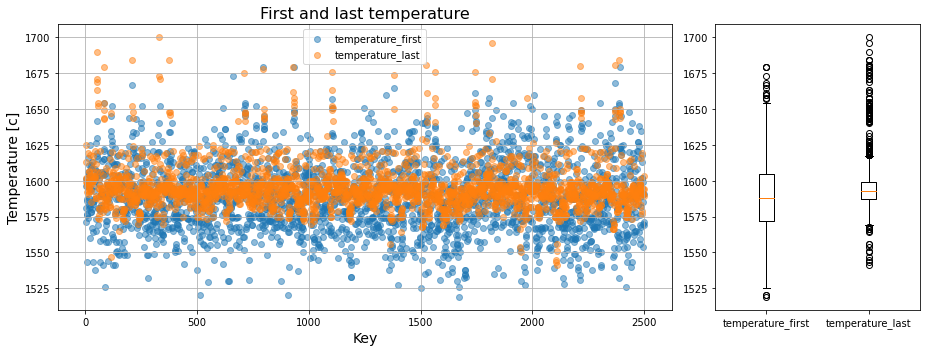

In [45]:
plot_scatter_box(df, ['temperature_first','temperature_last'], title='First and last temperature', xlabel='Key', ylabel='Temperature [c]')

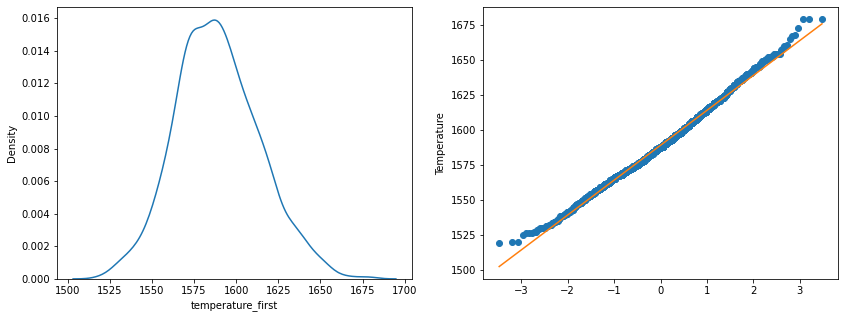

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(df['temperature_first'], ax=ax[0])
fig = probscale.probplot(
    df['temperature_first'],
    ax=ax[1],
    plottype='qq',
    bestfit=True
)
ax[1].set_ylabel('Temperature')
plt.show()

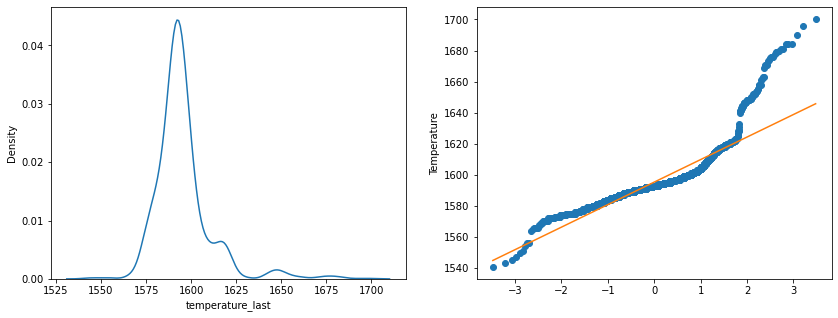

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.kdeplot(df['temperature_last'], ax=ax[0])
fig = probscale.probplot(
    df['temperature_last'],
    ax=ax[1],
    plottype='qq',
    bestfit=True
)
ax[1].set_ylabel('Temperature')
plt.show()

#### Построим график времени нагрева нагрева дугой

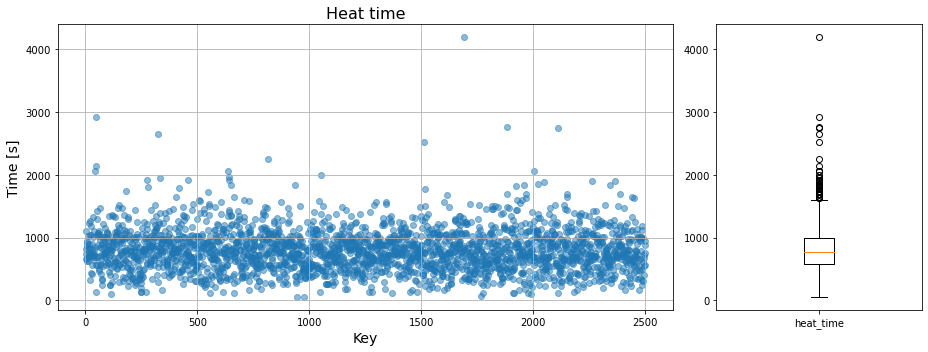

In [48]:
plot_scatter_box(df, ['heat_time'], title='Heat time', xlabel='Key', ylabel='Time [s]')

#### Построим график активной и реактивной мощности

In [49]:
df[['Активная мощность','Реактивная мощность']].describe()

,Активная мощность,Реактивная мощность
count,2475.000000,2475.000000
mean,3.127628,2.041593
std,1.425832,14.450978
min,0.186226,-714.591636
25%,2.148302,1.607333
50%,3.016373,2.229479
75%,3.908051,2.905603
max,17.496497,12.587990


Посчитаем отношение активной мощности к реактивной и заполним выброс в реактивной мощности расчётом из активной мощности.

In [50]:
df['power_ratio'] = df['Реактивная мощность'] / df['Активная мощность']

In [51]:
outlier = df.loc[df['Реактивная мощность'] < 0]
df.loc[df['Реактивная мощность'] < 0, ['Реактивная мощность']] = \
    outlier['Активная мощность'] * (df['power_ratio']).mean()

Пересчитаем соотношение мощностей, так как изменили одно значение реактивной мощности

In [52]:
df['power_ratio'] = df['Реактивная мощность'] / df['Активная мощность']

In [53]:
df['power_ratio'].describe()

count    2475.000000
mean        0.749933
std         0.087788
min         0.562708
25%         0.699220
50%         0.734806
75%         0.781552
max         1.641433
Name: power_ratio, dtype: float64

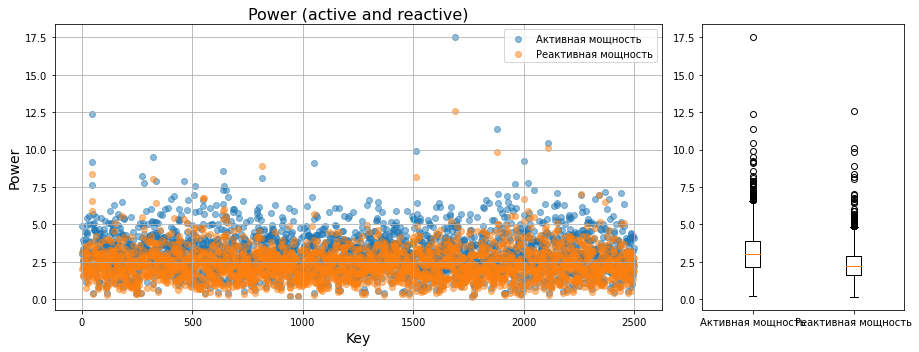

In [54]:
plot_scatter_box(df, ['Активная мощность','Реактивная мощность'], title='Power (active and reactive)', xlabel='Key', ylabel='Power')

Наблюдаем выбросы, оставим их как есть

#### Построим график по продувке сплава газом

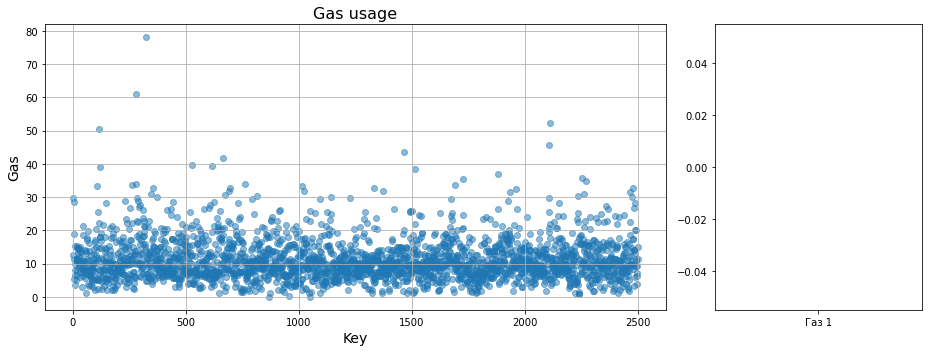

In [55]:
plot_scatter_box(df, ['Газ 1'], title='Gas usage', xlabel='Key', ylabel='Gas')

#### Рассмотрим распределение признаков

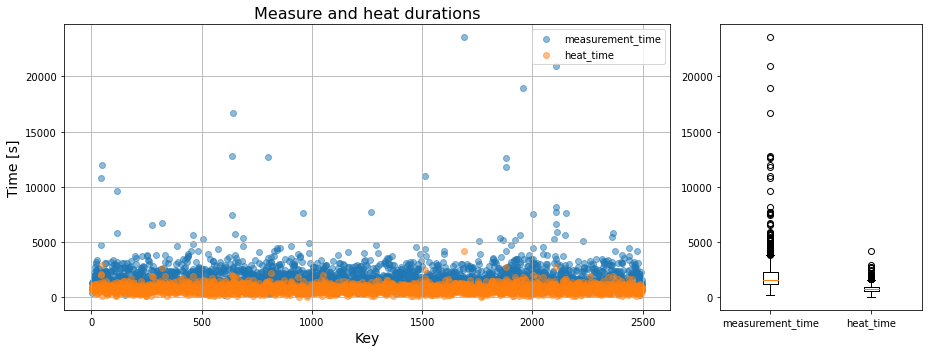

In [56]:
plot_scatter_box(df, ['measurement_time', 'heat_time'], title='Measure and heat durations', xlabel='Key', ylabel='Time [s]')

#### Построим распределение значений по материалам и газу

In [57]:
columns = [
    'Газ 1',
    'Wire 1',
    'Wire 2',
    'Bulk 1',
    'Bulk 3',
    'Bulk 4',
    'Bulk 6',
    'Bulk 10',
    'Bulk 11',
    'Bulk 12',
    'Bulk 14',
    'Bulk 15'
]

In [58]:
df[columns].describe()

,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
count,2473.000000,2372.000000,2372.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,11.142960,102.264474,17.856377,3.316577,46.057333,36.217698,21.940174,4.889074,4.107603,209.095970,153.823016,116.945160
std,6.323742,43.641222,33.944219,12.224364,74.619423,58.155923,55.218215,20.595391,22.160275,156.242143,81.902931,85.582306
min,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.105241,72.859018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000
50%,9.926730,101.087998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,149.000000,106.000000
75%,13.872219,128.143076,23.162880,0.000000,76.000000,75.000000,0.000000,0.000000,0.000000,283.000000,204.000000,204.000000
max,77.995040,330.314424,282.780152,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000


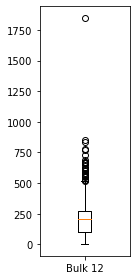

In [59]:
plt.figure(figsize=(2,4))
plt.boxplot(df['Bulk 12'].fillna(0), labels=['Bulk 12'])
plt.tight_layout()
plt.show()

Выделяется один выброс по `Bulk 12`

#### Посмотрим на значения взаимной корреляцию Пирсона между параметрами

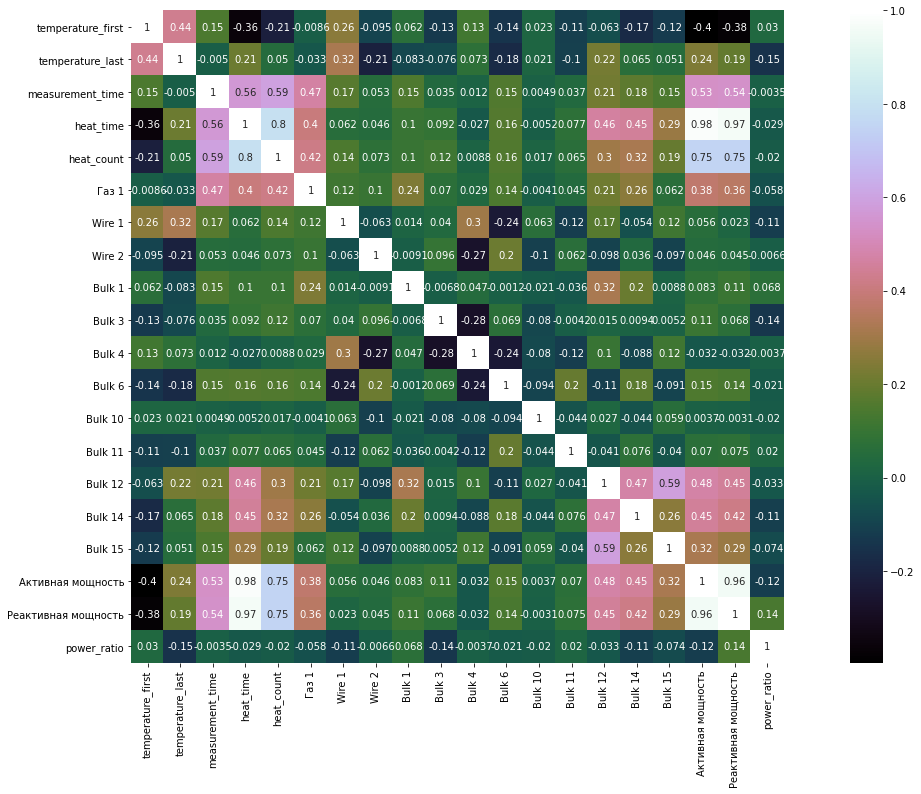

In [60]:
corr_mat=df.corr()
plt.figure(figsize=(24,12))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')
plt.show()

#### Построим график распределения и взаимной корреляции по выбранным параметрам

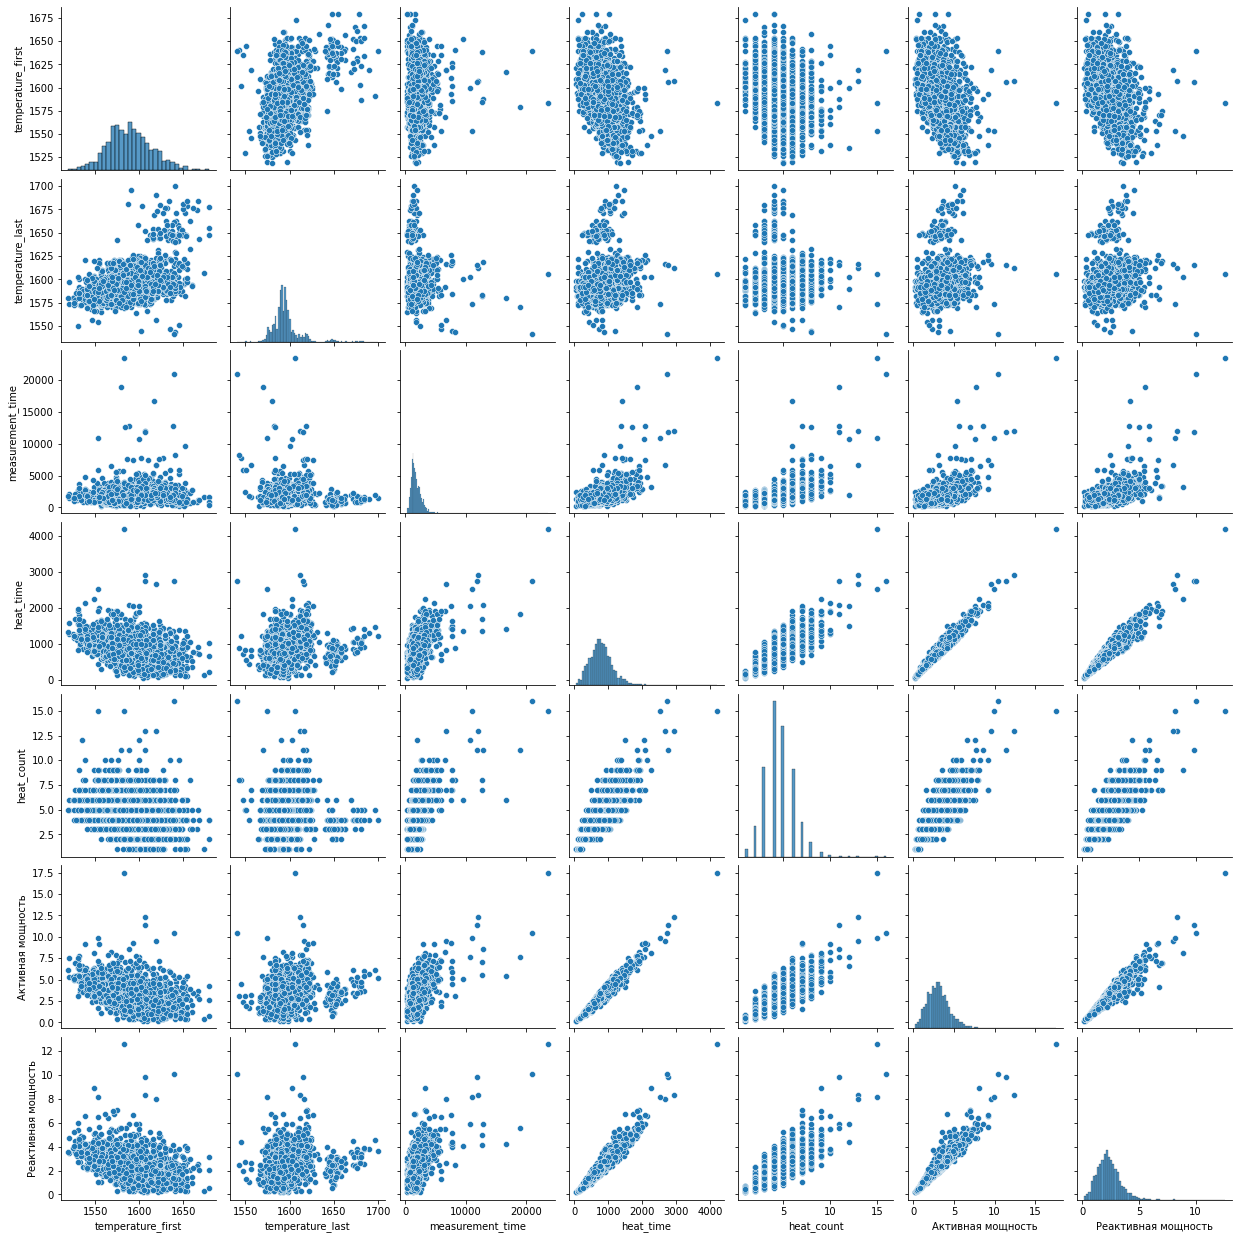

<Figure size 1440x1440 with 0 Axes>

In [61]:
sns.pairplot(df[[
    'temperature_first',
    'temperature_last',
    'measurement_time',
    'heat_time',
    'heat_count',
    'Активная мощность',
    'Реактивная мощность'
]])
plt.figure(figsize=(20,20))
plt.show()

Наблюдаем линейную зависимость мощности и времени нагрева

#### Вывод:
- по некоторым партиям полностью отсутствует информация о газе и о добавленных материалах
- во всех рассмотренных данных имеется некоторое количество выбросов
- избавились от аномального выброса по реактивной мощности
- выявлено сильную линейную зависимость между временем нагрева, активной и реактивной мощностью
- не выявлено каких-то изменений по признакам со временем
- имеется интервал отсутствия данных
- конечная температура больше всего линейно зависит от параметров: `начальная температура`, `активная мощность`, `реактивная мощность`, `время нагрева` и `Wire 1`

<a id="model"></a>
## 4. Построение модели

<a id="prepare"></a>
### 4.1 Подготовка данных для обучения модели

#### Сгенерируем дополнительные признаки

Из данных по мощности и времени создадим инфомацию по энергии

$$
Полная мощность = √ (Активная мощность2 + Реактивная мощность2)
$$

$$
W = Pt,    где W - Энергия, P - полная мощность, t - время
$$

In [62]:
df['Полная мощность'] = (df['Активная мощность'] - df['Реактивная мощность'])
df['energy'] = df['Полная мощность'] * df['heat_time']

<AxesSubplot:>

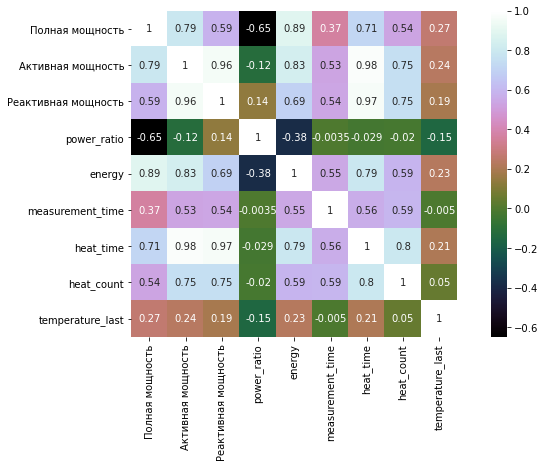

In [63]:
corr_mat=df[[
    'Полная мощность',
    'Активная мощность',
    'Реактивная мощность',
    'power_ratio',
    'energy',
    'measurement_time',
    'heat_time',
    'heat_count',
    'temperature_last']].corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

Выявлена мультиколлинеарность между полной мощностью и энергией дополнительно к ранее выявленной мультиколлинеарности активной и реактивной мощности друг к другу и к времени нагрева. Так же заметна мультиколлинеарность активной мощности и энергии, что очевидно, так как одна считается из другой.

Избавимся от признаков мощности, так как они уже учтены в энергии.

In [64]:
df = df.drop(['Полная мощность'], axis=1)
df = df.drop(['Реактивная мощность'], axis=1)
df = df.drop(['Активная мощность'], axis=1)
df = df.drop(['power_ratio'], axis=1)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature_first  2475 non-null   float64
 1   temperature_last   2475 non-null   float64
 2   measurement_time   2475 non-null   float64
 3   heat_time          2475 non-null   float64
 4   heat_count         2475 non-null   int64  
 5   Газ 1              2473 non-null   float64
 6   Wire 1             2372 non-null   float64
 7   Wire 2             2372 non-null   float64
 8   Bulk 1             2407 non-null   float64
 9   Bulk 3             2407 non-null   float64
 10  Bulk 4             2407 non-null   float64
 11  Bulk 6             2407 non-null   float64
 12  Bulk 10            2407 non-null   float64
 13  Bulk 11            2407 non-null   float64
 14  Bulk 12            2407 non-null   float64
 15  Bulk 14            2407 non-null   float64
 16  Bulk 15            2407 

По некоторым параметрам имеются пропуски, что мы уже ожидали, так ранее было выявлено отсутствие данных по материалам и при слиянии они заполнились как пропуски.

Заменим пропуски на нули.

In [66]:
df = df.fillna(0)
df.head(5)

,temperature_first,temperature_last,measurement_time,heat_time,heat_count,Газ 1,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,energy
key,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,861.0,1098.0,5,29.749986,60.059998,0.00000,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,1861.006292
2,1581.0,1602.0,1305.0,811.0,4,12.555561,96.052315,0.00000,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,855.188287
3,1596.0,1599.0,1300.0,655.0,5,28.554793,91.160157,0.00000,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,607.058089
4,1601.0,1625.0,388.0,741.0,4,18.841219,89.063515,0.00000,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,851.373736
5,1576.0,1602.0,762.0,869.0,4,5.413692,89.238236,9.11456,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,951.146607


#### Разделим исходные данные на обучающую и тестовую выборки в пропорции 3:1
Для сравнение результатов моделей будем использовать cross-validation. Если бы у нас было больше данных, то можно было бы использовать дополнительно отдельные валидационные данные.

In [67]:
target = df['temperature_last']
features = df.drop('temperature_last', axis=1)

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.25, random_state=91)

#### Масштабируем данные
Некоторые модели чувствительны с значениям, поэтому необходимо произвести масштабирование.
Используем StandardScaler, так как у нас нет большого количества сильных выбросов, да и требования к масштабированию не определены.

In [68]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

<a id="fit"></a>
### 4.2 Обучение и сравнение моделей

In [69]:
SEED = 91
CV_FOLDS = 6

Создадим функцию для добавления результатов работы моделей

In [70]:
model_results = {'name': [], 'model': [], 'cv_mae': [], 'training_time': []}

def add_model_result(name, model, mae, time):
    model_results['name'].append(name)
    model_results['model'].append(model)
    model_results['cv_mae'].append(mae)
    if time:
        model_results['training_time'].append(time)

Создадим функцию для работы с Grid Search

In [71]:
def generate_clf(X, y, model, parameters):
    clf = GridSearchCV(model, parameters, cv=CV_FOLDS, scoring='neg_mean_absolute_error', return_train_score=False, n_jobs=-1)
    clf.fit(X, y)
    return clf.best_estimator_, -clf.best_score_, clf
    print()

Параметры для Grid Search

In [72]:
from sklearn.neighbors import KNeighborsRegressor

model_params = {
    'SVM': {
        'model': svm.SVR(),
        'params' : {
            'kernel': ('linear', 'rbf'),
            'gamma': ('scale', 'auto'),
            'C': (5, 10, 20),
            'epsilon': (0.1, 0.25, 0.5, 0.75, 1.0)
        }  
    },

    'Desicion Tree': {
        'model': tree.DecisionTreeRegressor(criterion='mae', random_state=SEED), 
        'params' : {
            'max_depth': (5,6,7,8),
            'min_samples_leaf': range(2,7,2),
            'min_samples_split': range(3,8,2)
        }  
    },

#    'Random Forrest': { # to slow
#        'model': ensemble.RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=91),
#        'params' : {
#            'n_estimators': [200, 300],
#            'max_depth': (6,8),
#            'min_samples_leaf': (2,4),
#            'min_samples_split': range(3,8,2)
#        }  
#    }, 
#    
    'Ada Boost': {
        'model': ensemble.AdaBoostRegressor(random_state=SEED),
        'params' : {
            'n_estimators': [50, 150, 300],
            'learning_rate': (0.1, 0.5, 1, 2),
            'loss': ('linear', 'square', 'exponential')
        }  
    },

    'KNeighbors': {
        'model': KNeighborsRegressor(n_jobs=-1),
        'params' : {
            'n_neighbors': range(3,16,2),
            'leaf_size': (10, 30, 50),
            'algorithm': ('ball_tree', 'kd_tree', 'brute'),
            'p': (1, 2)
        }  
    }
}

#### Dummy Regressor
Для валидации наших моделей на корректность проверим МАЕ на модели предсказывающей среднее значение

In [73]:
start = tm.time()

# dummy regressor
predicted_dummy = pd.DataFrame([np.repeat(target_train.mean(), target_train.shape[0])], index=target_train.index)
mae_dummy = mean_absolute_error(target_train, predicted_dummy[0])
add_model_result('dummy_mean', target_train.mean(), mae_dummy, tm.time() - start)
print('Dummy mean model')
print(f'MAE: {mae_dummy:.2f}')

Dummy mean model
MAE: 10.27


#### Линейная регрессия
Обучим простую модель регрессии - линейную регрессию

In [74]:
start = tm.time()

model_linear = linear_model.LinearRegression()

scores = cross_val_score(model_linear, features_train, target_train, cv=CV_FOLDS, scoring='neg_mean_absolute_error')
mae_linear = -scores.mean()

add_model_result('Linear', model_linear, mae_linear, tm.time() - start)
print('Linear model')
print('MAE:', mae_linear)

Linear model
MAE: 7.107017112814291


#### Grid search (SVM, Desicion Tree, Ada Boost, KNN)

In [75]:
for model_name, mp in model_params.items():
    print(model_name)
    start = tm.time()
    model, mae, clf = generate_clf(features_train, target_train, mp['model'], mp['params'])
    add_model_result(model_name, model, mae, tm.time() - start)
    print(f"Fit time: {(tm.time() - start):.0f}s\n")

SVM
Fit time: 31s

Desicion Tree
Fit time: 12s

Ada Boost
Fit time: 24s

KNeighbors
Fit time: 5s



#### CatBoost

In [76]:
catboost_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'iterations': 3000,
    'early_stopping_rounds': 50,
    'silent': True,
    'thread_count': -1,
    'random_seed': SEED
}

In [77]:
%%time

model = CatBoostRegressor(**catboost_params)

grid_catboost = {
        'learning_rate': [0.02, 0.05],
        'depth': [3, 4, 5],
        'l2_leaf_reg': [2, 3, 4]
        }

grid_search_result = model.grid_search(grid_catboost, 
                                       X=features_train, 
                                       y=target_train)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.504605084
bestIteration = 2020

0:	loss: 6.5046051	best: 6.5046051 (0)	total: 2.77s	remaining: 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.715627256
bestIteration = 841

1:	loss: 6.7156273	best: 6.5046051 (0)	total: 3.69s	remaining: 29.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.646524346
bestIteration = 2785

2:	loss: 6.6465243	best: 6.5046051 (0)	total: 6.77s	remaining: 33.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.815879292
bestIteration = 1014

3:	loss: 6.8158793	best: 6.5046051 (0)	total: 7.86s	remaining: 27.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.792989354
bestIteration = 2794

4:	loss: 6.7929894	best: 6.5046051 (0)	total: 10.7s	remaining: 27.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.97474259
bestIteration = 952

5:	loss: 6.9747426	best: 6.5046051 (0)	total: 11.7s	remainin

In [78]:
start = tm.time()
    
model_catboost = CatBoostRegressor(**grid_search_result['params'], **catboost_params)
model_catboost.fit(features_train, target_train)

scores = cross_val_score(model_catboost, features_train, target_train, cv=CV_FOLDS, scoring='neg_mean_absolute_error')
mae_catboost = -scores.mean()

add_model_result('CatBoost', model_catboost, mae_catboost, tm.time() - start)
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 5.857441392363383


In [79]:
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 5.857441392363383


Промежуточные результаты моделей

In [80]:
df_results = pd.DataFrame(model_results)
df_results.sort_values('cv_mae')

,name,model,cv_mae,training_time
6,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,5.857441,24.772089
2,SVM,"SVR(C=20, epsilon=1.0)",6.123975,31.094528
5,KNeighbors,"KNeighborsRegressor(algorithm='ball_tree', lea...",7.047068,4.990637
1,Linear,LinearRegression(),7.107017,0.019997
4,Ada Boost,"(DecisionTreeRegressor(max_depth=3, random_sta...",7.236294,24.042562
3,Desicion Tree,"DecisionTreeRegressor(criterion='mae', max_dep...",7.330890,12.439917
0,dummy_mean,1595.329203,10.266685,0.111003


Посмотрим как каждый параметр влияет на целевой признак

In [81]:
feature_importance_df = pd.DataFrame(model_catboost.feature_importances_, index=features.columns)
feature_importance_df.sort_values(0)

,0
Bulk 10,0.205351
Bulk 11,0.296865
Bulk 3,0.463897
heat_count,0.545441
Bulk 4,1.262528
Газ 1,1.316635
Bulk 12,1.428985
Wire 2,1.849410
Bulk 15,1.851942
Bulk 14,2.130842


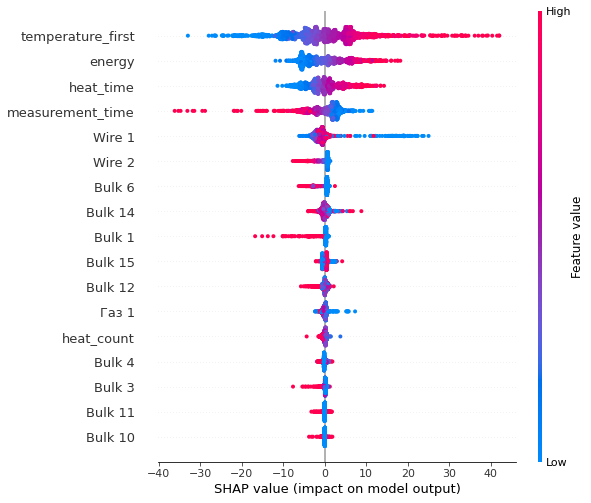

In [82]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model_catboost) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=features.columns.to_list())

Выявили, что некоторые параметры слабо влияют на конечный прогноз. С точки зрения физики параметр `heat_count` бесполезен, а у нас ещё есть более значимый признак - энергия потраченная на нагрев. По параметрам `Bulk 3`, `Bulk 10`, `Bulk 11` ещё и мало значений (примерно на 5% партий). Попробуем избавиться от них и сравним качество на моделях CatBoost и SVM.

In [83]:
df = df.drop(['Bulk 3', 'Bulk 10', 'Bulk 11', 'heat_count'], axis=1)

target = df['temperature_last']
features = df.drop('temperature_last', axis=1)

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.25, random_state=SEED)

features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

#### Переобучим Cat Boost на новом наборе признаков

In [84]:
%%time
model = CatBoostRegressor(**catboost_params)

grid_search_result = model.grid_search(grid_catboost, 
                                       X=features_train, 
                                       y=target_train)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.529321576
bestIteration = 2037

0:	loss: 6.5293216	best: 6.5293216 (0)	total: 2.16s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.010437466
bestIteration = 873

1:	loss: 7.0104375	best: 6.5293216 (0)	total: 3.21s	remaining: 25.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.64175895
bestIteration = 2853

2:	loss: 6.6417589	best: 6.5293216 (0)	total: 6.31s	remaining: 31.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.098082956
bestIteration = 1256

3:	loss: 7.0980830	best: 6.5293216 (0)	total: 7.59s	remaining: 26.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.882833957
bestIteration = 2702

4:	loss: 6.8828340	best: 6.5293216 (0)	total: 10.6s	remaining: 27.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.410283622
bestIteration = 1132

5:	loss: 7.4102836	best: 6.5293216 (0)	total: 11.9s	remai

In [85]:
start = tm.time()
    
model_catboost = CatBoostRegressor(**grid_search_result['params'], **catboost_params)
model_catboost.fit(features_train, target_train)

scores = cross_val_score(model_catboost, features_train, target_train, cv=CV_FOLDS, scoring='neg_mean_absolute_error')
mae_catboost = -scores.mean()

add_model_result('CatBoost_2', model_catboost, mae_catboost, tm.time() - start)
print(f"Model: {grid_search_result['params']}")
print(f'MAE: {mae_catboost}')

Model: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.02}
MAE: 5.855595033373519


In [86]:
feature_importance_df = pd.DataFrame(model_catboost.feature_importances_, index=features.columns)
feature_importance_df.sort_values(0)

,0
Bulk 4,1.567370
Газ 1,1.754540
Bulk 1,1.788437
Bulk 12,1.850236
Wire 2,1.979092
Bulk 15,2.033437
Bulk 14,2.499498
Bulk 6,2.541678
heat_time,5.841047
measurement_time,8.273826


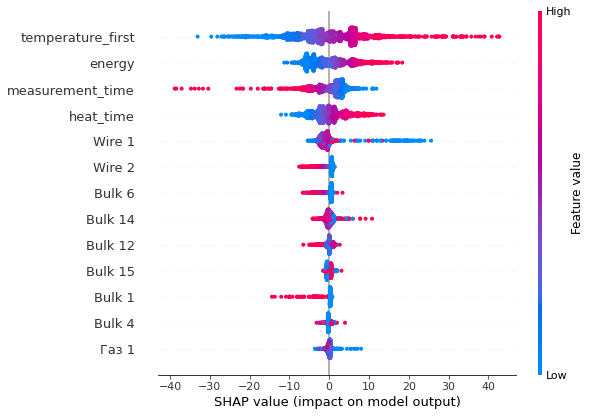

In [87]:
train_data = Pool(data=features_train,
                  label=target_train
                 )
                 
explainer = shap.TreeExplainer(model_catboost) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object
shap.summary_plot(shap_values, features_train, feature_names=features.columns.to_list())

Оставшиеся признаки имеют достаточную значимость

#### Переобучим SVM на новом наборе признаков

In [88]:
params = {
    'kernel': ('linear', 'rbf'),
    'gamma': ('scale', 'auto'),
    'C': (5, 10, 20),
    'epsilon': (0.1, 0.25, 0.5, 0.75, 1.0),
    'tol': (0.001, 0.01, 0.05)
}  

start = tm.time()

model, mae, clf = generate_clf(features_train, target_train, svm.SVR(), params)
add_model_result('SVM_2', model, mae, tm.time() - start)

#### Результаты по всем моделям

In [89]:
df_results = pd.DataFrame(model_results)
df_results.sort_values('cv_mae')

,name,model,cv_mae,training_time
7,CatBoost_2,<catboost.core.CatBoostRegressor object at 0x0...,5.855595,23.823919
6,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,5.857441,24.772089
8,SVM_2,"SVR(C=20, epsilon=1.0, tol=0.05)",6.088420,72.042261
2,SVM,"SVR(C=20, epsilon=1.0)",6.123975,31.094528
5,KNeighbors,"KNeighborsRegressor(algorithm='ball_tree', lea...",7.047068,4.990637
1,Linear,LinearRegression(),7.107017,0.019997
4,Ada Boost,"(DecisionTreeRegressor(max_depth=3, random_sta...",7.236294,24.042562
3,Desicion Tree,"DecisionTreeRegressor(criterion='mae', max_dep...",7.330890,12.439917
0,dummy_mean,1595.329203,10.266685,0.111003


#### Вывод:
- для подбора гиперпараметров использовали кросс-валидацию с разбивкой на 6 блоков
- обучили разные модели и лучше всего себя показали Cat Boost и SVM
- проанализировав значимость признаков избавились от `Bulk 3`, `Bulk 10` и `Bulk 11`, что почти не сказалось на качестве Cat Boost, но улучшило качество SVM

<a id="testing"></a>
## 5. Тестирование модели

Протестируем две лучшие модели на тестовых данных

#### Cat Boost

In [90]:
model = df_results[df_results['name']=='CatBoost_2'].iloc[0]['model']

predicted = model.predict(features_test)
test_mae_catboost = mean_absolute_error(target_test, predicted)
print(test_mae_catboost)

5.325636215988986


### SVM

In [91]:
model = df_results[df_results['name']=='SVM_2'].iloc[0]['model']

predicted = model.predict(features_test)
test_mae_svm = mean_absolute_error(target_test, predicted)
print(test_mae_svm)

5.368323046672804


In [92]:
df_test_mae = pd.DataFrame(data={'name': ['CatBoost_2', 'SVM_2'], 'test_mae': [test_mae_catboost, test_mae_svm]})
df_results = pd.merge(df_results, df_test_mae, how="left", on=["name"])
df_results.sort_values('cv_mae')

,name,model,cv_mae,training_time,test_mae
7,CatBoost_2,<catboost.core.CatBoostRegressor object at 0x0...,5.855595,23.823919,5.325636
6,CatBoost,<catboost.core.CatBoostRegressor object at 0x0...,5.857441,24.772089,NaN
8,SVM_2,"SVR(C=20, epsilon=1.0, tol=0.05)",6.088420,72.042261,5.368323
2,SVM,"SVR(C=20, epsilon=1.0)",6.123975,31.094528,NaN
5,KNeighbors,"KNeighborsRegressor(algorithm='ball_tree', lea...",7.047068,4.990637,NaN
1,Linear,LinearRegression(),7.107017,0.019997,NaN
4,Ada Boost,"(DecisionTreeRegressor(max_depth=3, random_sta...",7.236294,24.042562,NaN
3,Desicion Tree,"DecisionTreeRegressor(criterion='mae', max_dep...",7.330890,12.439917,NaN
0,dummy_mean,1595.329203,10.266685,0.111003,NaN


Лучшая модель Cat Boost с результатом метрики МАЕ **5.3**

<a id="conclusion"></a>
## 6. Общий вывод

В данных были выявлены пропуски и выбросы. Для подготовки данных к обучению модели был проведён анализ и обработка данных. В ходе обработки данных были выделены значимые признаки. Так же из существующих признаков были сгенерированы новые признаки, которые положительно сказались на качестве модели. По результатам обучения и сравнения различных моделей лучший результат показали Cat Boost и SVM, имеющие схожие значения метрики качества МАЕ. Стоит отметить, что модель SVM обучается гораздо быстрее, что можно учесть при выборе итоговой модели. Цель проекта выполнена, удалось достичь результата МАЕ < 6.0

В целях улучшения проекта стоит попробовать избавиться от данных (добавление материалов, замеры мощности и тд) которые получены после замера конечной температуры.

Так же для оптимизации производственных расходов рекомендуется уменьшить разброс в измерениях замеров температуры или необходимо создать систему которая бы определяла аномальные замеры.